# Model-free Renewable Scenario Generation Using Generative Adversarial Networks

### Yize Chen, Yishen Wang, Daniel Kirschen and Abosen Zhang

Grossly implemented by Pedro Bittencourt based on Yize Chen's original code on https://github.com/chennnnnyize/

For event-based scenario generation and spatial scenario generation, implement the code with labels or 
reshape the imput samples to spatio-temporal samples respectively.
16 is the maximum value for wind capacity we use. Change to the customized max value for normalized data
import ipdb

In [1]:
import os
import pandas as pd
import numpy as np
from model import *
from util import *
from load import load_wind, load_solar_data, load_wind_data_spatial #Change the data source for other tasks
from numpy import shape
import csv
import matplotlib.pyplot as plt

## Setup variables

In [2]:
n_epochs = 60 #Number of overall training epochs on training data
learning_rate = 0.0002 
batch_size = 32
image_shape = [24,24,1] #The shape for input data
dim_z = 100 #input dimension for samples
dim_W1 = 1024 #first layer neurons
dim_W2 = 128 #second layer neurons
dim_W3 = 64 #third layer#16 is the maximum value for wind capacity we use. Change to your max value here
dim_channel = 1 #reserved for future use if multi=channels
mu, sigma = 0, 0.1 # input Gaussian
events_num=5 #kind of events

visualize_dim=32
generated_dim=32

## Load datasets

Change here for different datasets

In [3]:
#Comment out corresponding part to reproduce the results for 
#wind_events_generation, solar_events_generation, spatial_generation respectively
trX, trY=load_wind()
#trX, trY=load_solar()
#trX, trY=load_spatial()

print("shape of training samples ", shape(trX))
print("Training data loaded")

(105120, 52)
Maximum value of wind 16.0
(105120, 52)
Shape TrX (9464, 576)
Label shape (9464, 1)
shape of training samples  (9464, 576)
Training data loaded


## Initialize GAN

In [4]:
dcgan_model = GAN(
    dim_y=events_num # Change parameters based on number of events
    #change paprameters here for model revision
    #dim_z: the dimension for input noise
    #W1,W2,W3: the dimension for convolutional layers
        )
print("W_DCGAN model initialized")

Instructions for updating:
Colocations handled automatically by placer.
W_DCGAN model initialized


In [5]:
#Z_tf,Y_tf: placeholder
#image_tf: image placeholder
#d_cost_tf, g_cost_tf: discriminator and generator cost#16 is the maximum value for wind capacity we use. Change to your max value here
#p_real, p_gen: the output of discriminator to judge real/generated
Z_tf, Y_tf, image_tf, d_cost_tf, g_cost_tf, p_real, p_gen = dcgan_model.build_model()
sess = tf.InteractiveSession()
saver = tf.train.Saver(max_to_keep=10)

discrim_vars = filter(lambda x: x.name.startswith('discrim'), tf.trainable_variables())
gen_vars = filter(lambda x: x.name.startswith('gen'), tf.trainable_variables())
discrim_vars = [i for i in discrim_vars]
gen_vars = [i for i in gen_vars]

train_op_discrim = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(-d_cost_tf, var_list=discrim_vars))
train_op_gen = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(g_cost_tf, var_list=gen_vars))

Z_tf_sample, Y_tf_sample, image_tf_sample = dcgan_model.samples_generator(batch_size=visualize_dim)
tf.initialize_all_variables().run()

Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
Y_np_sample = OneHot(np.random.randint(events_num, size=[visualize_dim]), n=events_num)
iterations = 0
k = 4 #control the balance of training D and G

gen_loss_all=[]#16 is the maximum value for wind capacity we use. Change to your max value here
P_real=[]
P_fake=[]
P_distri=[]
discrim_loss=[]

Initializing the generator
Input Z shape (32, 100)
Input Y shape (32, 5)
Z shape (32, 105)
h1 shape (32, 1024)
h1 shape (32, 1029)
h2 shape (32, 4608)
h2 shape (32, 6, 6, 128)
shape of yb new (32, 6, 6, 5)
h2 shape (32, 6, 6, 133)
h3 shape (32, 12, 12, 64)
h3 shape (32, 12, 12, 69)
Initializing the discriminator
Y shape (32, 5)
image shape (32, 24, 24, 1)
yb shape (32, 1, 1, 5)
X shape (32, 24, 24, 6)
h1 shape (32, 12, 12, 64)
h1 shape (32, 12, 12, 69)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)
Initializing the discriminator
Y shape (32, 5)
image shape (32, 24, 24, 1)
yb shape (32, 1, 1, 5)
X shape (32, 24, 24, 6)
h1 shape (32, 12, 12, 64)
h1 shape (32, 12, 12, 69)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [6]:
#begin training
for epoch in range(n_epochs):
    print("epoch" + str(epoch))
    index = np.arange(len(trY))
    np.random.shuffle(index)
    trX = trX[index]
    trY = trY[index]
    trY2 = OneHot(trY, n=events_num)

    for start, end in zip(
            range(0, len(trY), batch_size),
            range(batch_size, len(trY), batch_size)
            ):

        Xs = trX[start:end].reshape([-1, 24, 24, 1])
        Ys = trY2[start:end]

        #use uniform or Gaussian distribution data to generate adversarial samples
        Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)

        #for each iteration, generate g and d respectively, k=2
        if np.mod( iterations, k) == 0:
            _, gen_loss_val = sess.run(
                    [train_op_gen, g_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf: Xs
                        })
            discrim_loss_val, p_real_val, p_gen_val = sess.run([d_cost_tf,p_real,p_gen], feed_dict={Z_tf:Zs, image_tf:Xs, Y_tf:Ys})

            '''print("=========== updating G ==========")
            print("iteration:", iterations)
            print("gen loss:", gen_loss_val)
            print("discrim loss:", discrim_loss_val)'''

        else:
            _, discrim_loss_val = sess.run(
                    [train_op_discrim, d_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf:Xs
                        })

            '''print("=========== updating D ==========")
            print("iteration:", iterations)
            print("gen loss:", gen_loss_val)
            print("discrim loss:", discrim_loss_val)'''

            gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen],
                                                       feed_dict={Z_tf: Zs, image_tf: Xs, Y_tf: Ys})
        P_real.append(p_real_val.mean())
        P_fake.append(p_gen_val.mean())
        '''gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen],
                                                       feed_dict={Z_tf: Zs, image_tf: fake_data, Y_tf: Ys})'''
        discrim_loss.append(discrim_loss_val)


        if np.mod(iterations, 1000) == 0:
            print("iterations ", iterations)
            print("Average P(real)=", p_real_val.mean())
            print("Average P(gen)=", p_gen_val.mean())
            print("Discrim loss:", discrim_loss_val)
            Y_np_sample = OneHot(np.random.randint(5, size=[visualize_dim]), n=events_num)
            Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
            generated_samples = sess.run(
                image_tf_sample,
                feed_dict={
                    Z_tf_sample: Z_np_sample,
                    Y_tf_sample: Y_np_sample
                })
            generated_samples=generated_samples.reshape([-1,576])
            generated_samples = generated_samples * 16 #16 is the maximum value for wind capacity we use. Change to your max value here
            csvfile=open('%s.csv' %iterations, 'w')
            writer=csv.writer(csvfile)
            writer.writerows(generated_samples)

        iterations += 1

epoch0
iterations  0
Average P(real)= 0.33495608
Average P(gen)= 0.33550388
Discrim loss: -17.950195
epoch1
epoch2
epoch3
iterations  1000
Average P(real)= 0.38775358
Average P(gen)= 0.26468796
Discrim loss: 4032.6143
epoch4
epoch5
epoch6
iterations  2000
Average P(real)= 0.364366
Average P(gen)= 0.25534195
Discrim loss: 3572.5
epoch7
epoch8
epoch9
epoch10
iterations  3000
Average P(real)= 0.3766731
Average P(gen)= 0.25606072
Discrim loss: 3952.2266
epoch11
epoch12
epoch13
iterations  4000
Average P(real)= 0.37698337
Average P(gen)= 0.32127613
Discrim loss: 1825.415
epoch14
epoch15
epoch16
iterations  5000
Average P(real)= 0.37964106
Average P(gen)= 0.27437282
Discrim loss: 3449.4297
epoch17
epoch18
epoch19
epoch20
iterations  6000
Average P(real)= 0.362753
Average P(gen)= 0.29936168
Discrim loss: 2077.207
epoch21
epoch22
epoch23
iterations  7000
Average P(real)= 0.31889185
Average P(gen)= 0.2814684
Discrim loss: 1226.292
epoch24
epoch25
epoch26
epoch27
iterations  8000
Average P(real)

KeyboardInterrupt: 

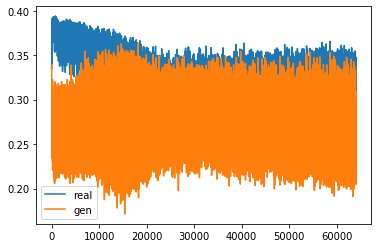

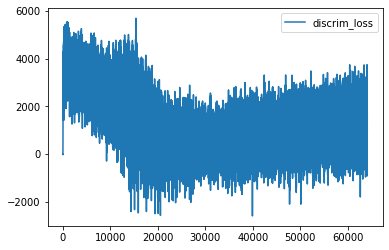

In [7]:
Y_np_sample = OneHot(np.random.randint(5, size=[visualize_dim]), n=events_num) 
Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
generated_samples = sess.run(
    image_tf_sample,
    feed_dict={
        Z_tf_sample: Z_np_sample,
        Y_tf_sample: Y_np_sample
    })
generated_samples=generated_samples.reshape([-1,576])
generated_samples = generated_samples * 16 #16 is the maximum value for wind capacity we use. Change to your max value here
csvfile=open('sample1.csv', 'w')
writer=csv.writer(csvfile)
writer.writerows(generated_samples)
csvfile=open('label1.csv', 'w')
writer=csv.writer(csvfile)
writer.writerows(Y_np_sample)


#plot the loss and P_real as well as P_fake
#print("P_real",P_real)
#print("P_fake",P_fake)

plt.plot(P_real,label="real")
plt.plot(P_fake,label="gen")
plt.legend()
plt.show()

plt.plot(discrim_loss,label="discrim_loss")
plt.legend()
plt.show()
